<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/Introduction_single_cell_RNA_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to single-cell RNA-seq

### Based on material taught in Caltech course Bi/BE/CS18 by Lior Pachter and Matt Thomson, with contributions from Sina Booeshaghi, Lambda Lu, Jialong Jiang, Eduardo Beltrame, Jase Gehring and Valentine Svensson.  

The rapid development of single-cell genomics methods starting in 2009 has created unprecedented opportunity for highly resolved measurements of cellular states. Among such methods, single-cell RNA-seq (scRNA-seq) is having a profound impact on biology. Here we introduce some of the key concepts of single-cell RNA-seq technologies, with a focus on droplet based methods.

## Setup

This notebook is a "living document". It downloads data and performs computations. As such it requires the installation of some python packages, which are installed with the commands below. In addition to running on Google Colab, the notebook can be downloaded and run locally on any machine which has python3 installed.

In [0]:
#@title Install packages
%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
import matplotlib.font_manager
import pandas as pd
from IPython.display import Math
from IPython.display import Latex
from IPython.display import display
import io
from mizani.breaks import date_breaks
from mizani.formatters import date_format
# Only pandas >= v0.25.0 supports column names with spaces in querys
import plotnine as p
import requests
import warnings
import colorsys
warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Motivation

The goal of single-cell transcriptomics is to measure the transcriptional states of large numbers of cells simultaneously. The input to a scRNA-seq method is a collection of cells, possibly from intact tissue, or in dissociated form. Formally, the desired output is a *genes x cells*  matrix that describes, for each cell, the abundance of its constituent transcripts. More generally, single-cell genomics methods seek to measure not just transcriptional state, but other modalities in cells, e.g. protein abundances, epigenetic states, cellular morphology, etc.

The ideal single-cell technology should thus:

- Be ***universal*** in terms of cell size, type and state.
- Perform ***in situ*** measurements.
- Have no ***minimum input*** requirements.
- Assay every cell, i.e. have a 100% ***capture rate***.
- Detect every transcript in every cell, i.e. have 100% ***sensitivity***.
- Identify individual transcripts by their ***full-length sequence***.
- Assign transcripts correctly to cells, e.g. no ***doublets***.
- Be compatible with additional ***multimodal measurements***.
- Be ***cost effective*** per cell.
- Be ***easy to use***.
- Be ***open source*** so that it is transparent, and results from it reproducible.

There is no method satisfying all of these requirements, however progress has been rapid. The development of single-cell RNA-seq technologies and their adoption by biologists, has been remarkable. [Svensson et al. 2019](https://www.biorxiv.org/content/10.1101/742304v2) describes a database of articles which involve single-cell RNA-seq experiments, and the graph below, dynamically produced from the [current version of the database](https://docs.google.com/spreadsheets/d/1En7-UV0k0laDiIfjFkdn7dggyR7jIk3WH8QgXaMOZF0/edit#gid=0), makes clear the initial exponential growth in use of the assay:

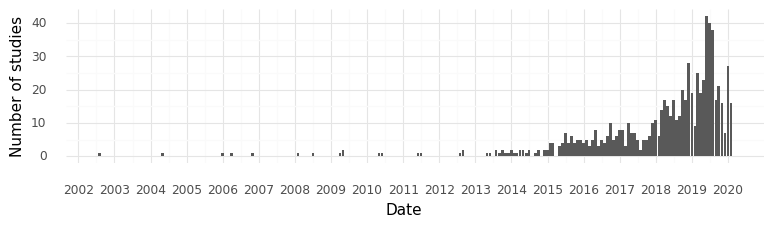

<ggplot: (-9223363281185755669)>


In [30]:
#@title Growth of single-cell RNA-seq
df = pd.read_csv('http://nxn.se/single-cell-studies/data.tsv', sep='\t')
# converts string to date format, can only be run once!
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# converts string of reported cells total to float, can only be run once!
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

# plot number of studies over time
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI'), data=df.resample('1M', on='Date').count()[['DOI']].reset_index())
    + p.geom_bar(stat='identity')
    + p.theme_minimal(base_family='DejaVu Sans')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies')
)
print(fig)

There are many different scRNA-seq technologies in use and under development, but broadly they fall into a few main categories: well-based methods, droplet-based methods, and spatial transcriptomics approaches. At the time of initial writing of this document (2019), droplet-based approaches have become popular due to their relative low-cost, easy of use, and scalability. This is evident in a breakdown of articles by technology used: 

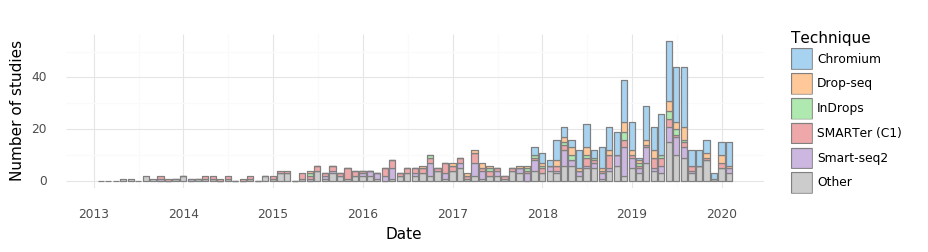

<ggplot: (-9223363281181208611)>

In [31]:
#@title Technologies used
def tidy_split(df, column, sep='|', keep=False):

    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    
    return new_df

ts = pd.Timestamp

tdf = tidy_split(df, 'Technique', ' & ')
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')
tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

def desaturate(color, prop):
    
    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color

    # lighten matplotlib default colors
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))

#### Plot number of studies per month by technique
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Technique'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='DejaVu Sans')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)
fig

## Droplet-based methods

We therefore focus on droplet-based methods, although we note that many of the concepts we introduce are relevant for other technologies as well.

Droplet based single-cell RNA-seq methods were popularized by a pair of papers published concurrently in 2015: 
- [Macosko et al., Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets, 2015. DOI:10.1016/j.cell.2015.05.002](https://www.cell.com/fulltext/S0092-8674(15)00549-8) describes Drop-seq.
- [Klein et al., Droplet barcoding for single-cell transcriptomics applied to embryonic stem cells, 2015. DOI:10.1016/j.cell.2015.04.044](https://www.cell.com/cell/fulltext/S0092-8674(15)00500-0) descibes inDrops.

Both of the methods makes use of developments in microfluidics published in:
- Song, Chen, Ismagilov, Reactions in droplets in microfluidic channels, 2006. DOI:10.1002/anie.200601554
- Guo, Rotem, Heyman and Weitz, Droplet microfluidics for high-throughput biological assays, 2012. DOI:10.1039/C2LC21147E

The key to these methods is the encapsulation of cells in droplets forming a mono-dispersed emulsion. 


In [0]:
# !wget https://www.annualreviews.org/na101/home/literatum/publisher/ar/journals/content/biodatasci/2018/biodatasci.2018.1.issue-1/annurev-biodatasci-080917-013452/20180705/images/large/bd10029.f2.jpeg

In [0]:
# image = plt.imread("bd10029.f2.jpeg")

In [0]:
#fig, ax = plt.subplots(figsize=(15,15))
# ax.imshow(image)
# ax.axis('off')  # clear x-axis and y-axis

In [35]:
Testing some math

from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx')


SyntaxError: ignored

python notebook 

Equation 1
$$\frac{sin(x)}{x}$$

foo bar 

Equation 2
\begin{equation}
F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx
\end{equation}


Binomial distribution is defined on a finite set consisting of all the possible results of $N$ tries of an experiment with a binary outcome, $0$ or $1$. If $p$ is the probability of getting a $1$ and $1-p$ that of getting a $0$, the probability that $k$ out of the $N$ tries yield a $1$ is:
 
 $P(k\ 1s\ out\ of\ N) = \binom{N}{k}p^k(1-p)^{N-k}$
 
 it mean is $\mu = Np$ and variance is $\sigma^2=Np(1-p)$

In [0]:
from scipy.stats import binom
b = binom.rvs(n=10, p=0.5, size=10000)

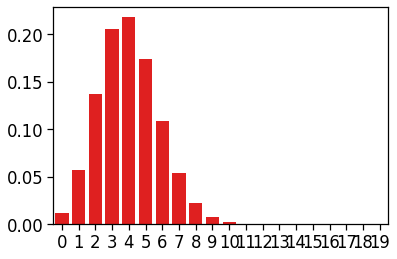

In [67]:
sns.barplot(x=np.arange(20), y=binom.pmf(np.arange(20),20,0.2), color='r')

In [0]:
from scipy.stats import poisson

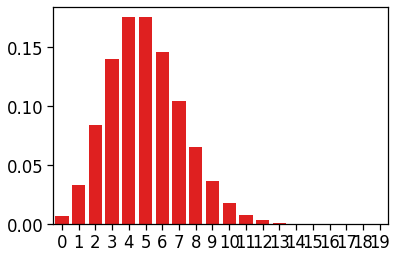

In [70]:
sns.barplot(x=np.arange(20), y=poisson.pmf(np.arange(20),5), color='r')